# Statistical static timing analysis via modern optimization lens

## Implementation Section

We have prototyped the formulations in [CVXPY](https://www.cvxpy.org/). For benchmarking
purposes, we have rewritten the formulations of the integer programs in [Mosek’s matrix-oriented API](https://docs.mosek.com/latest/pythonapi/index.html)
and ran the instances an 8-processor machine
equipped with Intel Xeon Scalable Platinum 8160 (192 cores at 2.1GHz and
384 hardware threads) with 1536 GB RAM. In this Jupyter notebook, you can find the results that ran on Mosek 10.0 on Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz with 16GB RAM.

In [1]:
import src.timing.infiniteLadder as infiniteLadder
import numpy as np
from src.timing.ScalingAlgorithms import *
import src.utility_tools.Plotter as Plotter
import sys
import subprocess

%load_ext autoreload
%autoreload 2

### GP model with fixed number of gates

Fig. 7 in the paper demonstrates the scalability of the reformulated GP on a ladder
of maxima and convolutions, parameterized by the number of bins per gate.
Notice that the numbers of cones (blue line) and variables (orange line) are
quadratic in the number of bins. At the same time, MAPE decreases with the
number of bins, as expected.

In [18]:
# set parameters
numberOfIterations=5
step=5
numberOfGates=3
numBinsStart=15
interval=(-4, 25)

xs = [numberOfIterations, step, numberOfGates, numBinsStart, interval[0], interval[1]]
args = ' '.join(str(x) for x in xs)

In [19]:
# Uncomment to run on your own machine
p = subprocess.run("python3 ../src/timing/ScalingAlgorithms.py GP_bins " + args + " > ../inputs_outputs/logBins.txt", shell=True)


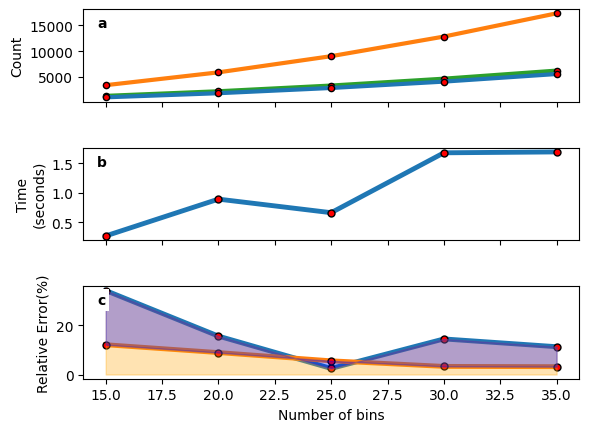

In [20]:
Plotter.plotPresolve("../inputs_outputs/logBins.txt", bins=True)

### GP model with fixed number of bins

The results on a ladder of maximums and convolutions parameterized
by the depth of the ladder are shown in Fig. 6 in the paper. Notice that the numbers of
cones (blue line) and variables (orange line) are linear in the depth of the
ladder. At the same time, the maximum absolute percentage error (MAPE)
increases, which may be due to the fixed number of bins utilized

In [5]:
# set parameters
numberOfIterations=9
step=2
numberOfBins=25
numGatesStart=3
interval=(-4, 25)

xs = [numberOfIterations, step, numberOfBins, numGatesStart, interval[0], interval[1]]
args = ' '.join(str(x) for x in xs)

In [6]:
# Uncomment to run on your own machine
p = subprocess.run("python3 ../src/timing/ScalingAlgorithms.py GP_gates " + args + " > ../inputs_outputs/logGates.txt", shell=True)


Traceback (most recent call last):
  File "/home/bosadam/Documents/FEL/GP/GP-Optimization/examples/../src/timing/ScalingAlgorithms.py", line 482, in <module>
    scalingGates_CVXPY_GP(numberOfIterations=int(args[2]), step=int(args[3]), numberOfBins=int(args[4]), numberOfGatesStart=int(args[5]), interval=(int(args[6]), int(args[7])))
  File "/home/bosadam/Documents/FEL/GP/GP-Optimization/examples/../src/timing/ScalingAlgorithms.py", line 282, in scalingGates_CVXPY_GP
    lastGate, time = infiniteLadder.mainCVXPY_GP(numGates, numberOfBins, interval)
  File "/home/bosadam/.local/lib/python3.10/site-packages/src/timing/infiniteLadder.py", line 340, in mainCVXPY_GP
    prob.solve(
  File "/home/bosadam/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 481, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/bosadam/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 1020, in _solve
    self.unpack_results(solution, solving_chain, inverse_d

ValueError: x and y must have same first dimension, but have shapes (2,) and (3,)

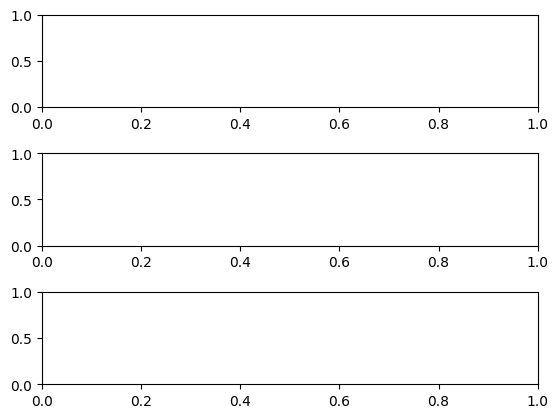

In [4]:
Plotter.plotPresolve("../inputs_outputs/logGates.txt", bins=False)

### MIP model - Comparison

Comparison of 3 methods of the SSTA realization. The methods are
tested on a “ladder” of maximums and convolutions. The blue line indicates the original method, the orange line indicates a method with separation
constraints and the green line indicates a method with separation constraints and a three-term multiplication model.

In [2]:
# set parameters 
numberOfIterations=3
step=3
numberOfBins=15
numGatesStart=1
numberOfUnaries=15
interval=(-4, 25)

In [3]:
        # test integer program with and without relaxations
TRI = False
Constr = False
res1 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

TRI = False
Constr = True
res2 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

TRI = True
Constr = True
res3 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 182280          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 78750           
  Matrix variables       : 0               
  Integer variables      : 78750           

Optimizer started.
Mixed integer optimizer started.
Threads used: 8
Presolve started.
Presolve terminated. Time = 0.18, probing time =  0.01
Presolved problem: 250 variables, 635 constraints, 1713 non-zeros
Presolved problem: 3 general integer, 247 binary, 0 continuous
Clique table size: 421
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        -0.0000000000e+00    NA                   NA          0.5   
0        1        1        0        6.0000000000

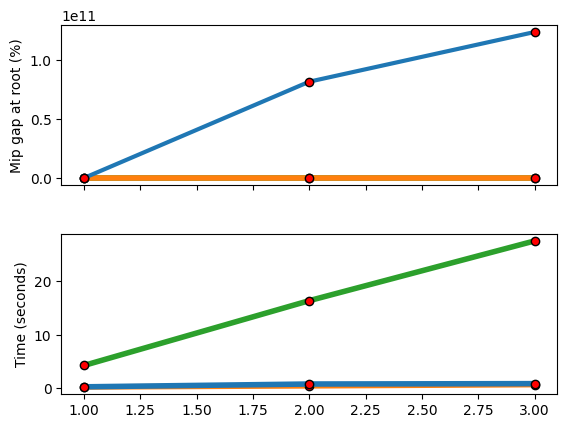

In [16]:
# Plot the results 
# - blue line indicates the unrelaxed problem
# - orange line indicates relaxed problem with symmetry breaking constraints
# - green line indicates the fully relaxed

Plotter.plotComparison(res1, res2, res3)

### Fully relaxed problem using MIP

The number of variables and constraints introduced in each convolution/maximum is very large, especially in
the case of a tighter formulation with separation constraints and a three-term
multiplication model. However, if we look at Figure 5 in the paper, we can also see that the
number of constraints and variables scale linearly with the number of gates,
and that many variables can be removed by pre-solve routines, as evidenced
by the number of non-zeros after pre-solve. The near-zero relative (MIP) gap
at the root node of the branch-and-bound tree is a sign of a good formulation.

In [24]:
# set parameters
numberOfIterations=3
step=1
numberOfBins=15
numGatesStart=1
numberOfUnaries=15
interval=(-4, 25)

In [25]:
TRI = True
Constr = True
res = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 16740225        
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 4185900         
  Matrix variables       : 0               
  Integer variables      : 4185900         

Optimizer started.


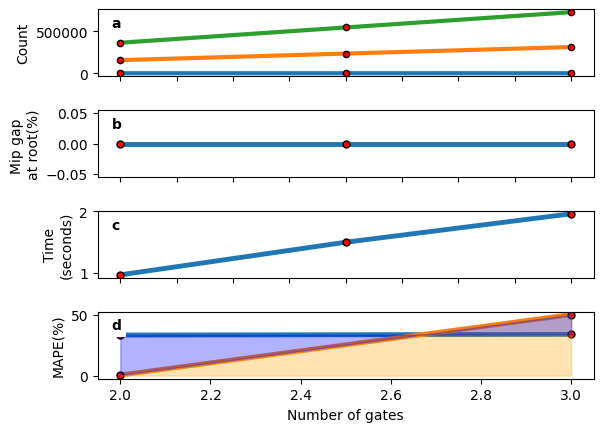

In [23]:
Plotter.plotNonzeros(res)